# Predicting Bike Rentals in Washington D.C.



### Introduction

In the United States, many cities have bike sharing systems in place. One such city is Washington D.C., and in this project, I attempt to predict the total number of bikes people rented in a given hour. To accomplish this task, I explore several machine learning techniques to determine an effective prediction model. The techniques used in this project include the linear regression, decision tree, and random forest. The data used in this project was assembled by Hadi Fanaee - T, and it can be accessed through the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). 

I begin by reading in the data:

In [1]:
import pandas as pd

bike_rentals = pd.read_csv(r'C:\Users\Daniel\Desktop\hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Where the columns are defined as the following:

<font color='maroon'>instant</font> - A unique sequential ID number for each row<br>
<font color='maroon'>dteday</font> - The date of the rentals<br>
<font color='maroon'>season</font> - The season in which the rentals occurred<br>
<font color='maroon'>yr</font> - The year the rentals occurred<br>
<font color='maroon'>mnth</font> - The month the rentals occurred<br>
<font color='maroon'>hr</font> - The hour the rentals occurred<br>
<font color='maroon'>holiday</font> - Whether or not the day was a holiday<br>
<font color='maroon'>weekday</font> - The day of the week (as a number, 0 to 7)<br>
<font color='maroon'>workingday</font> - Whether or not the day was a working day<br>
<font color='maroon'>weathersit</font> - The weather (as a categorical variable)<br>
<font color='maroon'>temp</font> - The temperature, on a 0-1 scale<br>
<font color='maroon'>atemp</font> - The adjusted temperature<br>
<font color='maroon'>hum</font> - The humidity, on a 0-1 scale<br>
<font color='maroon'>windspeed</font> - The wind speed, on a 0-1 scale<br>
<font color='maroon'>casual</font> - The number of casual riders (people who hadn't previously signed up with the bike sharing program)<br>
<font color='maroon'>registered</font> - The number of registered riders (people who had already signed up)<br>
<font color='maroon'>cnt</font> - The total number of bike rentals (casual + registered)<br>

### Data Exploration

I then explored the data by building a histogram of the cnt column and performing a correlation analysis between cnt and the other variables. The histogram shows us the distribution of a given variable, while the set of correlations will provide a good understanding of the unconditional association between cnt and the other variables. 

The histogram shows that the data are right skewed and there doesn't seem to be any noticeable outliers.

Text(0, 0.5, 'Frequency')

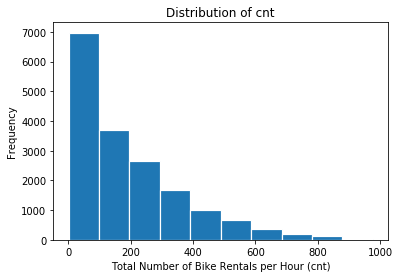

In [2]:
import matplotlib.pyplot as plt

plt.hist(bike_rentals['cnt'], edgecolor = 'white', linewidth = 1.2)
plt.title('Distribution of cnt')
plt.xlabel('Total Number of Bike Rentals per Hour (cnt)')
plt.ylabel('Frequency')

In the set of correlations below, I saw that the relevant variables with relatively higher correlations include season, yr, mnth, hr, weathersit, temp, and hum. Although holiday, weekday, workingday, and windspeed have weaker correlations with cnt, intuitively, it made sense to include these variables in our models. 

The rest of the variables were ignored for the following reasons:

1. casual and registered: The sum of these two variables make up cnt
2. atemp: This variable is a modified version of the temp variable
3. instant: This variable is ordinal in nature 

In [3]:
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

### Data Cleaning

In this dataset, the hour (hr) column can be misinterpreted by the machine. I wanted the machine to understand that certain ranges of hours indicate different parts of the day, such as morning, afternoon, evening, and night. So, I created a separate column, time_label, that includes this distinction. 

In [4]:
def assign_label(unit_hr):
        if unit_hr >= 0 and unit_hr < 6:
            return 4
        elif unit_hr >= 6 and unit_hr < 12:
            return 1
        elif unit_hr >= 12 and unit_hr < 18:
            return 2
        elif unit_hr >= 18 and unit_hr <= 24:
            return 3    

bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


### Creating Training and Testing Sets

Now that the data has been cleaned, I created a training set that has 80% of the observations and a testing set that is comprised of the reminaing 20%.

In [5]:
train = bike_rentals.sample(frac = 0.8, random_state = 1)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

print(train.shape)
print(test.shape)

(13903, 18)
(3476, 18)


## Machine Learning Models

### Linear Regression 

The first model I built is the linear regression. I started by initiating a list of the columns in our dataset that I'll use for all the models. From that list, I then remove the variables that I described earlier were not relevant for prediction. Having all the components for the regression, I trained the model on the training set, and then predicted labels in the testing set.

Notice that I calculated the mean squared error (MSE). I included an error metric to evaluate the precision of my models.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

predictors = list(train.columns)
predictors.remove('dteday')
predictors.remove('casual')
predictors.remove('registered')
predictors.remove('cnt')
predictors.remove('instant')
predictors.remove('atemp')

reg = LinearRegression()
reg.fit(train[predictors], train['cnt'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [33]:
test_predictions = reg.predict(test[predictors])

mean_squared_error(test['cnt'], test_predictions)

17091.349737316126

### Decision Tree

The second model that I built is the decision tree. The decision tree can be used for both classification and regression problems. The problem with the decision tree is that it is prone to overfitting. The issue with an overfitting model is that it becomes less generalizable. So, to tackle this issue, I built a for-loop to test several values for the min_samples_leaf parameter to determine which value yields the least error.

The decision tree's predictions were better than that of the linear regression, and of the different values for the min_samples_leaf parameter, the value of 9 was optimal. This value produced an MSE of 2900.42.

In [34]:
from sklearn.tree import DecisionTreeRegressor

for samples_leaf in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    dt = DecisionTreeRegressor(random_state = 1, min_samples_leaf = samples_leaf)
    dt.fit(train[predictors], train['cnt'])
    dt_predictions = dt.predict(test[predictors])
    dt_mse = mean_squared_error(test['cnt'], dt_predictions)
    print('The mean squared error using a min_samples_leaf value of', samples_leaf,'is', dt_mse)

The mean squared error using a min_samples_leaf value of 1 is 3702.3895281933255
The mean squared error using a min_samples_leaf value of 2 is 3194.2686836721646
The mean squared error using a min_samples_leaf value of 3 is 3200.3710573296253
The mean squared error using a min_samples_leaf value of 4 is 3134.592705856029
The mean squared error using a min_samples_leaf value of 5 is 2967.3464579696442
The mean squared error using a min_samples_leaf value of 6 is 2864.759217062146
The mean squared error using a min_samples_leaf value of 7 is 2904.8605318161217
The mean squared error using a min_samples_leaf value of 8 is 2906.230280479011
The mean squared error using a min_samples_leaf value of 9 is 2900.4229746223677
The mean squared error using a min_samples_leaf value of 10 is 2920.6582614043996


### Random Forest

Finally, I built the random forest model. The random forest model is an ensemble technique that combines the results of a group of trees. In my model, I went with the default number of trees - 10. This is another way of dealing with possible overfitting from a single decision tree. Similar to the decision tree, I built a for-loop for this method as well. 

Overall, the random forest model yielded better predictions than the decision tree. For this method, a min_samples_leaf value of 2 was optimal, which produced an MSE value of 1974.41.

In [35]:
from sklearn.ensemble import RandomForestRegressor

for samples_leaf in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    rdf = RandomForestRegressor(random_state = 1, min_samples_leaf = samples_leaf)
    rdf.fit(train[predictors], train['cnt'])
    rdf_predictions = rdf.predict(test[predictors])
    rdf_mse = mean_squared_error(test['cnt'], rdf_predictions)
    print('The mean squared error using a min_samples_leaf value of', samples_leaf,'is', rdf_mse)

The mean squared error using a min_samples_leaf value of 1 is 1989.33002572768
The mean squared error using a min_samples_leaf value of 2 is 1974.410541305359
The mean squared error using a min_samples_leaf value of 3 is 2044.2836077036457
The mean squared error using a min_samples_leaf value of 4 is 2119.2614531008885
The mean squared error using a min_samples_leaf value of 5 is 2180.213363568855
The mean squared error using a min_samples_leaf value of 6 is 2235.889044924815
The mean squared error using a min_samples_leaf value of 7 is 2315.4165270721273
The mean squared error using a min_samples_leaf value of 8 is 2390.603592792489
The mean squared error using a min_samples_leaf value of 9 is 2476.2865500669077
The mean squared error using a min_samples_leaf value of 10 is 2551.8479230158714


### Conclusion



In this project, I built three machine learning models to predict the total number of bikes rented in a given hour. After having evaluated the three models using the MSE error metric, I determined that the random forest model had the best predictive power. It was able to reduce any overfitting that the decision tree is prone to while producing more accurate results. 